In [4]:
#Imports
import pandas as pd
import os
import glob
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from scipy import stats



First, we will analyze all of the data in the Disruptions folder. This will be done in the codeblock below



Successfully loaded and combined 14 files with a total of 55,864 disruptions.
Delays over 334.5 minutes were filtered and not used

--- Datasets loaded ---

--- Performing Statistical Significance Test ---
Peak Hour Disruption Rate: 0.68 disruptions/hour
Off-Peak Hour Disruption Rate: 0.37 disruptions/hour
Chi-squared statistic: 4164.170308133041
P-value: 0.0
Conclusion: The difference in disruption rates is statistically significant with p value: 0.0.


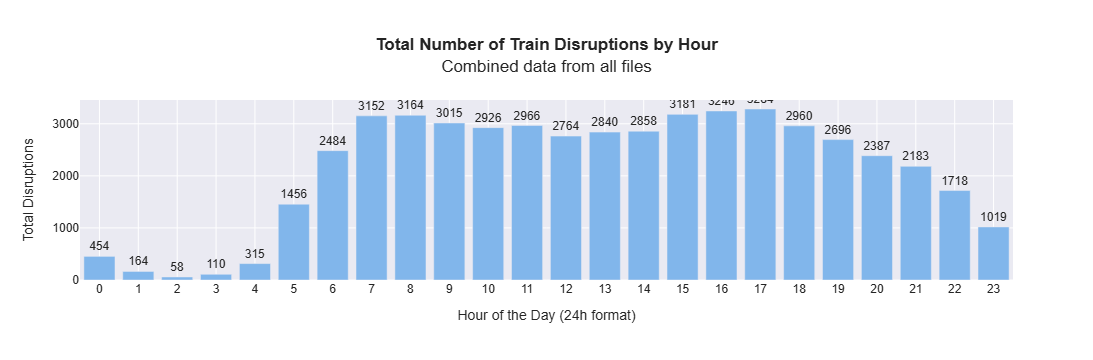

In [14]:
disruptions_folder = 'TIL Programming/Disruptions'

def process_disruptions_data(folder_path):
    """
    Args:
        folder_path (str): The path to the folder containing the disruption CSVs.

    Returns:
        pandas.DataFrame: A combined and processed DataFrame of all disruptions.
    """
    csv_files = glob.glob(os.path.join(folder_path, "disruptions-*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in '{folder_path}'. Please check the path.")
        return None

    df_list = [pd.read_csv(file) for file in csv_files]

    disruptions_df = pd.concat(df_list, ignore_index=True)
    print(f"Successfully loaded and combined {len(csv_files)} files with a total of {len(disruptions_df):,} disruptions.")

    
    disruptions_df['start_time'] = pd.to_datetime(disruptions_df['start_time'])
    disruptions_df['end_time'] = pd.to_datetime(disruptions_df['end_time'])

    Q1 = disruptions_df['duration_minutes'].quantile(0.25)
    Q3 = disruptions_df['duration_minutes'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR    
    print(f"Delays over {upper_bound} minutes were filtered and not used")
    outliers = disruptions_df[disruptions_df['duration_minutes'] > upper_bound]    
    df = disruptions_df[disruptions_df['duration_minutes'] <= upper_bound].copy()
    
    df['start_hour'] = df['start_time'].dt.hour

    is_weekday = df['start_time'].dt.weekday < 5
    is_morning_peak = (df['start_hour'] >= 6) & (df['start_hour'] < 9)
    is_evening_peak = (df['start_hour'] >= 16) & (df['start_hour'] < 19)
    df['is_peak'] = (is_weekday & (is_morning_peak | is_evening_peak))    
    
    return df

disruptions_data = process_disruptions_data(disruptions_folder)

if disruptions_data is not None:
    print("\n--- Datasets loaded ---")
    print("\n--- Performing Statistical Significance Test ---")
    #Determine peak disruption count
    peak_disruptions = disruptions_data['is_peak'].sum()
    off_peak_disruptions = len(disruptions_data) - peak_disruptions
    total_disruptions = len(disruptions_data)

    #Determine how many unique days in all data
    unique_days = disruptions_data['start_time'].dt.normalize().unique()
    num_weekdays = sum(pd.to_datetime(day).weekday() < 5 for day in unique_days)
    total_peak_hours = num_weekdays * 6 # 3 peak hours morning + 3 peak hours evening
    total_hours = len(unique_days) * 24
    total_off_peak_hours = total_hours - total_peak_hours

    peak_rate = peak_disruptions / total_peak_hours
    off_peak_rate = off_peak_disruptions / total_off_peak_hours
    print(f"Peak Hour Disruption Rate: {peak_rate:.2f} disruptions/hour")
    print(f"Off-Peak Hour Disruption Rate: {off_peak_rate:.2f} disruptions/hour")
    expected_peak = total_disruptions * (total_peak_hours / total_hours)
    expected_off_peak = total_disruptions * (total_off_peak_hours / total_hours)
    observed = [peak_disruptions, off_peak_disruptions]
    expected = [expected_peak, expected_off_peak]
    chi2_stat, p_value = stats.chisquare(f_obs=observed, f_exp=expected)
    print(f"Chi-squared statistic: {chi2_stat}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print(f"Conclusion: The difference in disruption rates is statistically significant with p value: {p_value}.")
    else:
        print(f"Conclusion: The difference in disruption rates is not statistically significant with p value: {p_value}.")    
    hourly_counts = disruptions_data['start_hour'].value_counts().sort_index().reset_index()
    hourly_counts.columns = ['Hour', 'Number of Disruptions']

    fig = px.bar(
        hourly_counts,
        x='Hour',
        y='Number of Disruptions',
        title='<b>Total Number of Train Disruptions by Hour</b><br>Combined data from all files',
        labels={'Hour': 'Hour of the Day (24h format)', 'Number of Disruptions': 'Total Disruptions'},
        template='seaborn',
        text='Number of Disruptions'
    )
    fig.update_layout(
        xaxis=dict(tickmode='linear', dtick=1),
        font_family="Arial",
        title_x=0.5
    )
    fig.update_traces(
        marker_color='rgb(129, 182, 235)',
        textposition='outside'
    )
    fig.show()




Next, we will analyze the daily checkins. 

